#### Setup

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../src') # Add source code to path

# Import source code
from user_interaction import welcome_message, model_decider, collect_values
from preprocessing import load_data 
from models import full_pipeline, calculate_rmse
from features import feature_engineering, scaling, add_constant_column
from final_function_source import final_function






# Read in the dataset
df = load_data()


# Introduction


### *Towards a better understanding of the world's health landscape*

Life expectancy is a statistical measurement used to estimate an individual's lifespan. Our aim as a team is to provide you with a tool that can accurately predict this estimate.

*So why should this matter to you?*

On an individual level, life expectancy is crucial in determining one's plans, support and care. On a larger group level, it holds paramount socio-economical implications.

On a country level, it is used to derive insights, analytics and further studies to better understand the needs & risk factors of populations.

# Agenda
1. Data Overview & EDA
2. Data Preparation
3. Model Training
4. Model Testing
5. Walkthrough of our function
6. Conclusion


## 1. Data Overview & Exploratory Data Analysis


To begin, we needed to ensure the model was built on sound, representative data for optimum accuracy. In an initial exploratory stage, we performed an overview to assess the current state of the data, conducted checks, and corrected any missing or misrepresentative data.

### Overview

We identified that our dataset includes a range of features capturing socio-economic, health, and demographic statistics, spanning 179 countries over a 16 year period.

In [2]:
df.shape

(2864, 21)

In [3]:
df.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


### Data Cleaning

We were fortunate that the dataset required minimal cleaning. It contained no missing values, duplicates, or data entry inconsistencies. All feature names were suitable for modelling, and the only outlier identified for further review was GDP_per_capita, which we addressed later during the feature engineering and transformation stage.

We also understood that two models were to be developed: one using the full dataset and another excluding sensitive information. We classified specific identifiers and any health-related records as sensitive data, while information that is publicly accessible was considered non-sensitive.

### Correlations:

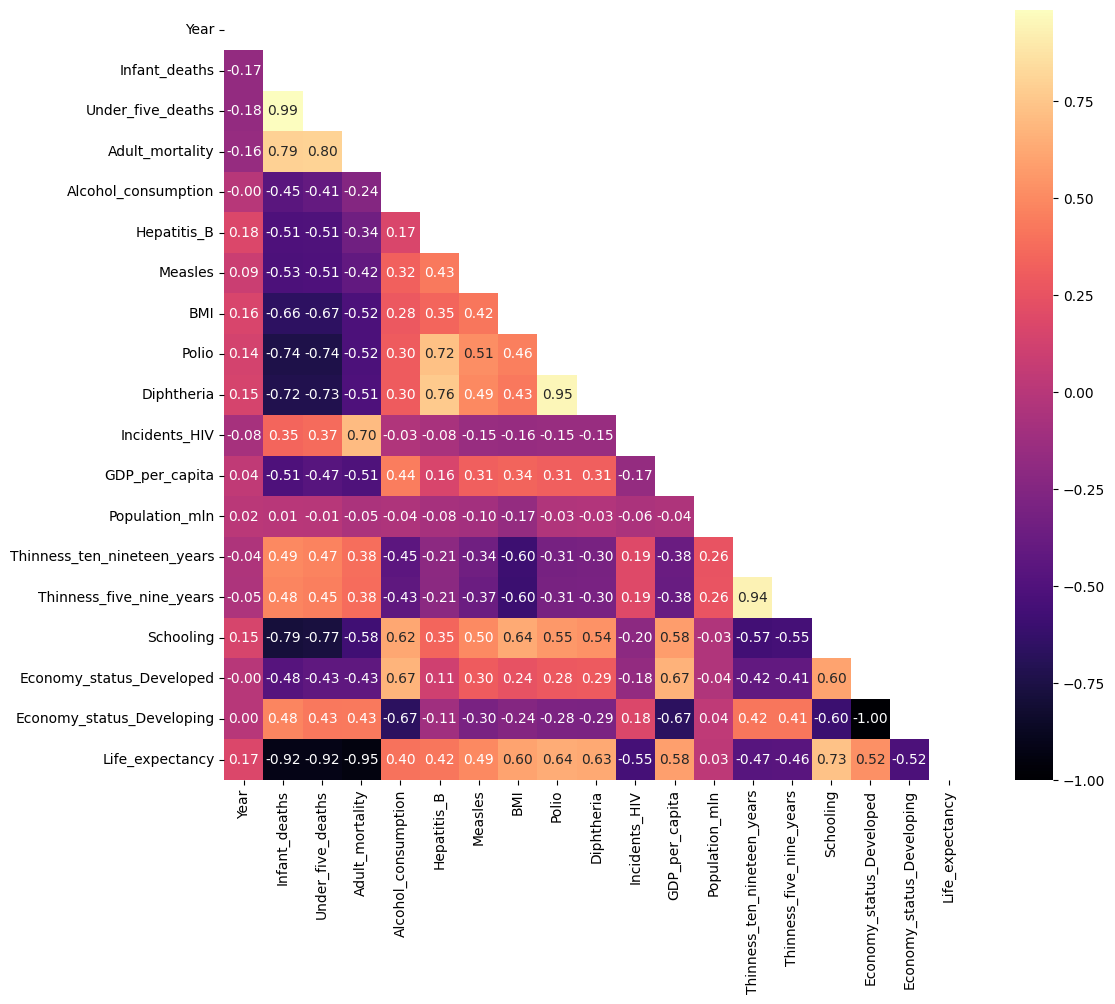

In [40]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='magma',
            mask = np.triu(corr_matrix))
plt.savefig('../visualisations/correlation', bbox_inches='tight')
plt.show()


<img src = '../visualisations/correlation.png'>

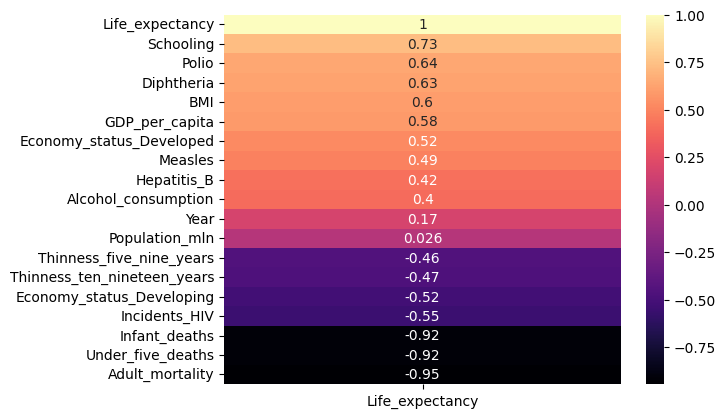

In [41]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['Life_expectancy']].sort_values(by='Life_expectancy', 
            ascending=False), 
            annot=True,
            cmap='magma')

plt.savefig('../visualisations/life_expectancy_correlations', bbox_inches = 'tight')
plt.show()

<img src = '../visualisations/life_expectancy_correlations.png' style="width:auto; height:auto;">

<img src = '../visualisations/pairplot1.png'>

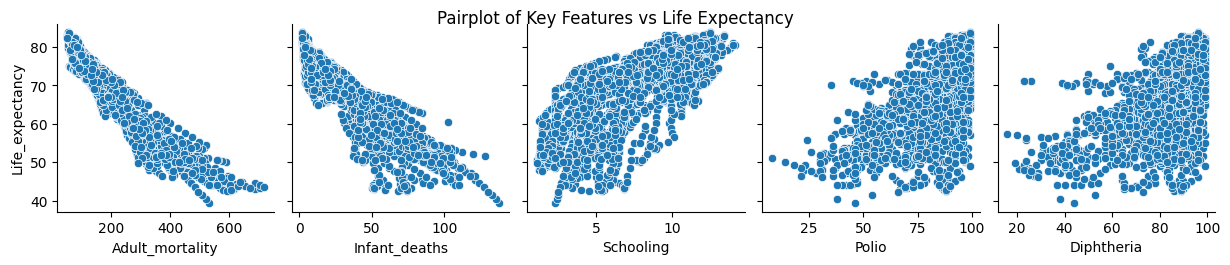

In [44]:
cols = [ 
        'Adult_mortality',
        'Infant_deaths',
        'Schooling',
        'Polio',
        'Diphtheria',
]

sns.pairplot(
    df, 
    x_vars=cols,
    y_vars=['Life_expectancy'],
)
plt.suptitle('Pairplot of Key Features vs Life Expectancy', y=1.02)
plt.savefig('../visualisations/pairplot2', bbox_inches = 'tight')
plt.show()

### Summary of Findings

Identified Key Features:

- Adult Mortality
- Infant Deaths
- Schooling
- Polio
- Diphtheria
- BMI
- GDP per Capita
- Economy Status (Developed)
- Measles
- Thinness (Ages 10–19)

Overview:

- The dataset is clean, with no major missing values or duplicate entries.

- Both numerical and categorical features have been clearly identified.

- Outlier inspection and correlation analysis highlight several variables with strong potential impact.

- We discovered potential multicollinearity. This can impact model performance by making it harder to interpret which variables truly drive predictions.

- The data is now well-prepared for the preprocessing and modeling stages.

# **2. Data preparation**  

## **Determine:**  
#### - _**Sensitive vs. non-sensitive data**_
#### - _**Strongly correlated features (Multicollinearity)**_

|**Non-sensitive**|**Sensitive**|
|:---|:---|
|Country|Alcohol consumption|
|Region|Immunisation rates against Hep B, Measles, Polio, Diphtheria|
|Year|BMI|
|**Infant mortality**|Incidence of HIV|
|**Under five mortality**|**Child thinness (5-9 years)**|
|Adult mortality|**Child thinness (10-19 years)**|
|GDP per capita||
|Population||
|Schooling||
|**Economically developed**||
|**Economically developing**||

Pairs of features in **bold** are expected to be linearly dependent, and to cause multicollinearity

## **Train-test split**

<img src="https://images.unsplash.com/photo-1748280933446-c9be297ec3be?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=1170" width = 400px, height=300px/>

## **Feature engineering**   

#### _Optimising the dataset for linear regression modelling_

<img src = '../visualisations/pearsons.png'>

##### Engineered dataset has a **more linear trend**, and the effect of **outliers** has been reduced.  

##### Features such as total population produced a **weak correlation** with life expectancy and have been **removed from the model**.

## **Normalisation**  

#### Using _Robust Scaler_

<img src = '../visualisations/normalisation.png'>

##### The **distribution** is unchanged, but the scale (x-axis) has been normalised for consistency with other features.

## Model building

We decided to use a linear regression model for the following reasons:
- It's simple and easy to interpret.
- It goes well with visuals.
- The pattern is highly repeatable, such that we can use it to reliably predict future instances.
- It's transparent and gives us an idea as to which features are more or less relevant.

The formula for a linear regression model is given as follows:

$ \hat{y} $ = b<sub>0</sub> + b<sub>1</sub>X<sub>1</sub> + b<sub>2</sub>X<sub>2</sub> + ... + b<sub>n</sub>X<sub>n</sub>     


where y (predictor) is the target we are trying to predict (in this case, life expectancy), the X's are our predictors (features such as GDP, levels of disease, etc), and the b's are our coefficients (how much our features are multipled by).

#### Model building - data sensitivity
Another concern we needed to consider was that some of the data we needed to analyse might be considered sensitive. Some countries might not be able/willing to show us some of the more private pieces of data around them, e.g. BMI, incidents of HIV, etc, due to the more private nature of those kinds of information.
To mitigate this concern, we seperated the featuires into 2 categories: sensitive and non-sensitive. We based non-sensitive data on the idea of the data not being considered private and geberally larger scale, examples including but not limited to:
- GDP
- level of education
- level of economic develeopment

Whereas the more personal private data was classed as sensitive, such as:
- BMI
- Incidents of HIV
- People classed as 'thin'

Our program gives you the option to use 1 of 2 models. One is for all data, regardless of sensitivity, and the other model is based soley on the data that is only considered non-sensitive. 
#### Model building - coefficients bar chart

We can visualise what the coefficients of the 2 models would look like with the following bar chart:

<img src = '../visualisations/elaborate_corr.png'>

<img src = '../visualisations/minimal_corr.png'>

## Model testing

In this notebook, the model is evaluated using the test dataset obtained from the train-test split. This steps helps to assess how well the model performs on unseen data and ensures that it can generalise beyond the training set.

The evaluation uses RMSE, MAE and R-squared to measure prediction accuracy and model fit. RMSE and MAE capture the average error in predictions whereas, R-squared indicates how well the model explains the variance in data.

## Train a model

In [18]:
minimal_cols = ['Region',
                'Under_five_deaths',
                'Adult_mortality',
                'GDP_per_capita',
                'Schooling',
                'Economy_status_Developed',
                'Life_expectancy'
                ]

elaborate_cols = minimal_cols + [
                  'Alcohol_consumption',
                  'Hepatitis_B',
                  'Measles',
                  'BMI',
                  'Polio',
                  'Diphtheria',
                  'Incidents_HIV',
                  'Thinness_ten_nineteen_years',
                  'Thinness_five_nine_years',
                 ]

## Model pipeline overview
The full_pipeline function below allows us to automate data preparation and model training.

This function performs the train-test split, feature engineering, scaling and model fitting. It then returns the processed data and trained model.

The pipeline has been run twice. Once using the minimal feature set (minimal_cols) and once using elaborate feature set (elaborate_cols). This allows comparison between the two - the simpler and more complex models to see which performs better.

In [19]:
X_train_m_fe, X_test_m_fe, y_train_m, y_test_m, minimal_results, scaler_m, training_columns_m = full_pipeline(minimal_cols)
X_train_e_fe, X_test_e_fe, y_train_e, y_test_e, elaborate_results, scaler_e, training_columns_e = full_pipeline(elaborate_cols)

## Testing our minimal model

In this section, we tested how well the minimal model makes predictions on the training data. This was done using the .predict() function which outputs the model's predicted values for the same inputs it was trained on. 

The root mean squared error (RMSE) was then calculated between the predicted values and actual values in the training set. The same was carried out for the test dataset, which the model had not been shown before. This helps to evaluate how well the model works on unseen data. 

In [23]:
# Make prediction (assuming model results saved as an object called 'results'
y_train_m_pred = minimal_results.predict(X_train_m_fe)

# Calculate RMSE from train data
minimal_rmse_train = calculate_rmse(y_train_m, y_train_m_pred)

print(f'Root Mean Squared Error for training data: {minimal_rmse_train}')

Root Mean Squared Error for training data: 1.420312266166898


In [24]:
# Do the same thing as above but with TEST data
y_test_m_pred = minimal_results.predict(X_test_m_fe)

minimal_rmse_test = calculate_rmse(y_test_m, y_test_m_pred)

print(f'Root Mean Squared Error for testing data: {minimal_rmse_test}')

Root Mean Squared Error for testing data: 1.411767033259221


The RMSE for the training data is 1.42 and the testing data is 1.41. Both values are almost identical which shows that the model performs consistently on both the data it was trained on and the unseen data. This shows that the model is *not* overfitting and is able to perform well on new unseen data.

The RMSE value itself shows that on average, the model's predictions differ only from the true value by approximately 1.4 years. This indicates a good level of accuracy for this model. 

# Testing our elaborate model

In [25]:
# Make prediction (assuming model results saved as an object called 'results'
y_train_e_pred = elaborate_results.predict(X_train_e_fe)

# Calculate RMSE from train data
elaborate_rmse_train = calculate_rmse(y_train_e, y_train_e_pred)

print(f'Root Mean Squared Error for training data: {elaborate_rmse_train}')

Root Mean Squared Error for training data: 1.3946036666072652


In [26]:
# Do the same thing as above but with TEST data
y_test_e_pred = elaborate_results.predict(X_test_e_fe)

elaborate_rmse_test = calculate_rmse(y_test_e, y_test_e_pred)

print(f'Root Mean Squared Error for testing data: {elaborate_rmse_test}')

Root Mean Squared Error for testing data: 1.3877250880253615


The RMSE for our training data is 1.395 and the testing data is 1.388. The RMSE's for our elaborate model are slightly lower than for that of the minimal model, showing that it performs better overall when compared to the minimal model as it makes smaller prediction errors.

Both training and testing RMSE values are similar showing that this model is not overfitting and is able to generalise well on given data. In summary, the elaborate model provides a small improvement in accuracy while also maintaining strong performance.

# 7 Demonstration

## Walkthrough

**Time for some audience paticipation!**

In [28]:
final_function()

Welcome to the WHOligans life expectancy predictor

Do you consent to using advanced population data, 
which may include protected information, for better accuracy? (Y/N): 
Please enter either Y or N
Thank you, your response was: N 

Please enter the region in which the country is located. Pick from the following list ['Middle East', 'European Union', 'Asia', 'South America', 'Central America and Caribbean', 'Rest of Europe', 'Africa', 'Oceania', 'North America']
Please enter the under-five mortality rate (per 1,000 people). Expected range is 2.3 to 224.9
Please enter the adult mortality rate (per 1,000 people aged 15-60 years). Expected range is 49.384 to 719.3605
Please enter the country's GDP per capita (in USD). Expected range is 148 to 112418
Please enter the average number of years of schooling. Expected range is 1.1 to 14.1
Please determine whether the country is economically developed. Enter 1 for yes, and 0 for no

Here is a copy of your responses:
 {'Region': 'Asia', 'Under_f

np.float64(51.821179314962706)

# 8 Conclusion

## Key Findings

1. (insert here) is the strongest predictor

2. 

## Limitations

* Correlation != Causation

* **Data Constrains**
    * Only have the years 2000-2015
    * Lots of external factors are not captured

## Future Directions

* Improve our elaborate model

* Give the user more control with the final function